In [1]:
from oipd import RND, MarketInputs, ModelParams
from oipd.core.svi import svi_options

import matplotlib.pyplot as plt
from datetime import date

['2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-14', '2025-11-21', '2026-01-16', '2026-04-17', '2026-06-18', '2026-10-16', '2027-01-15', '2027-09-17', '2027-12-17', '2028-01-21']


/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/prep.py:108: UserWarning: Filled missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(


Underlying price 24.4100 (source: vendor), implied forward price 27.5399; dividends: none, forward-implied annualised dividend yield of -40.3037%; days_to_expiry=99; r=0.0417526866591093;


/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/density.py:29: UserWarning: Non-uniform grid detected. Using np.gradient fallback which may be less stable. Consider interpolating to a uniform grid first.
  warnings.warn(


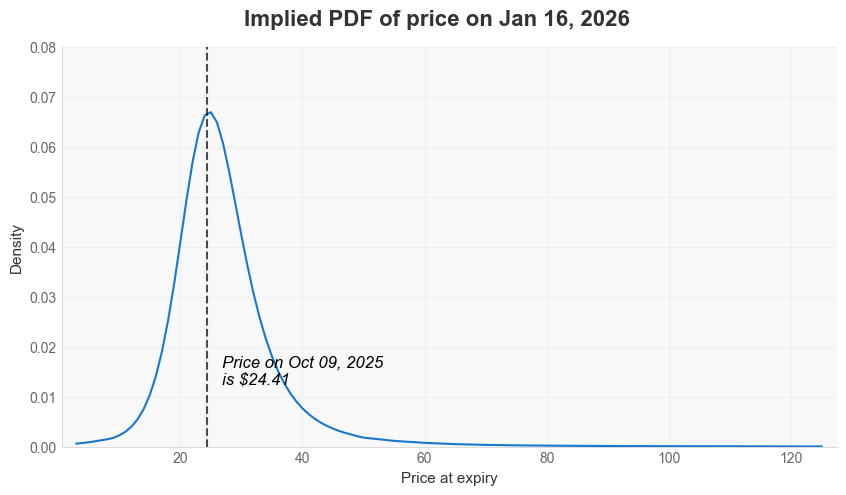

'Underlying price 24.4100 (source: vendor), implied forward price 27.5399; dividends: none, forward-implied annualised dividend yield of -40.3037%; days_to_expiry=99; r=0.0417526866591093;'

In [2]:
# --- Example 1 - GME --- #
# --- using yfinance connection --- #

# 1. Get a list of available expiry dates
expiry_dates = RND.list_expiry_dates("GME")
print(expiry_dates[:])  # ['2025-09-05', '2025-09-12', '2025-09-19',...]

# 2. Use ticker data with market parameters (current price fetched automatically)
market = MarketInputs(
    valuation_date=date.today(),
    expiry_date=date(2026, 1, 16),
    risk_free_rate=0.04199, # US 3-month nominal Treasury yield
)

model_gme = ModelParams(price_method="mid", max_staleness_days=None)

# 3. Fetch and estimate - auto-fetched data is available in the result
est_gamestop = RND.from_ticker("GME", market, model=model_gme)

# 4. Check the final market parameters used in estimation
est_gamestop.market

# 5. Plot using the result object
est_gamestop.plot(kind='pdf') # optional: `kind="pdf"` or `kind="cdf"`
plt.show()

# 6. Access results
# probability of price at or above a certain level
est_gamestop.prob_at_or_above(100)

# probability of price below a certain level
est_gamestop.prob_below(100)

# get results as a dataframe
est_gamestop.to_frame()

# see all the parameters that were used in the estimation
est_gamestop.summary()


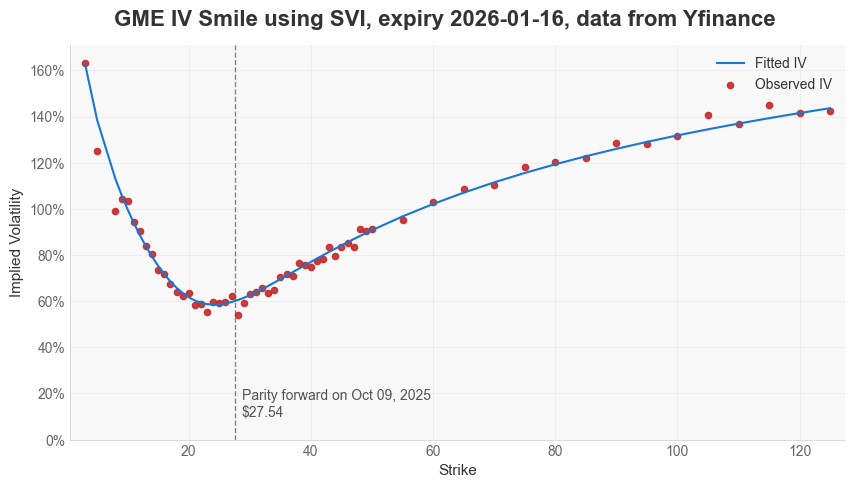

,strike,fitted_iv,bid_iv,ask_iv,last_iv
0,3.0,1.630095,NaN,NaN,1.630395
1,5.0,1.384597,NaN,NaN,1.251445
2,8.0,1.128800,NaN,NaN,0.988953
3,9.0,1.059855,NaN,NaN,1.044455
4,10.0,0.996759,NaN,NaN,1.034511


In [3]:
# plot fitted IV smile
est_gamestop.plot('iv_smile', title="GME IV Smile using SVI, expiry 2026-01-16, data from Yfinance")
plt.show()

est_gamestop.iv_smile().head()

/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/io/reader.py:92: UserWarning: Optional columns not present: {'last_trade_date'}.
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/density.py:29: UserWarning: Non-uniform grid detected. Using np.gradient fallback which may be less stable. Consider interpolating to a uniform grid first.
  warnings.warn(


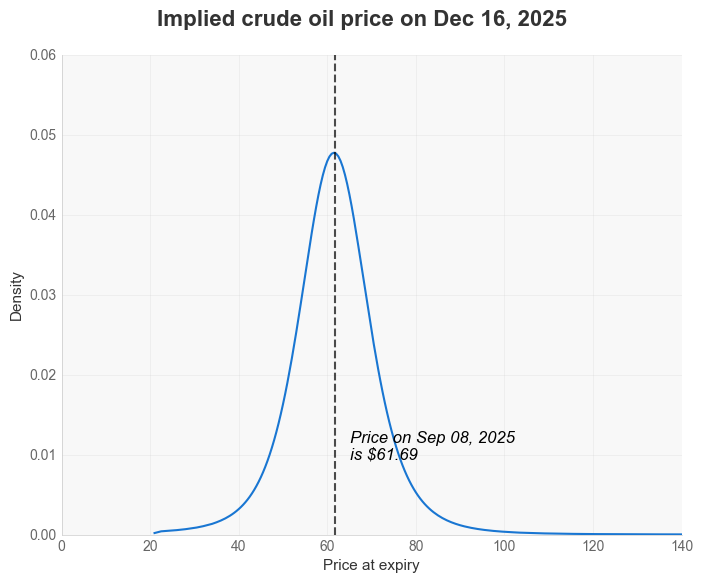

0.02364101206230598


In [4]:
# --- Example 2 - Crude Oil WTI --- #
# --- using csv file --- #

#  1. Column mapping (CSV headers → OIPD fields)
column_mapping_wti = {
    "Strike": "strike",
    "Last": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "Type": "option_type",
}

# 2. market parameters
market_wti = MarketInputs(
    underlying_price=61.69,  # current price of the underlying instrument on valuation date
    valuation_date=date(2025, 9, 8),
    expiry_date=date(2025, 12, 16),
    risk_free_rate=0.04199,  # US 3-month nominal Treasury yield
)

# 3. optional model knobs (could omit)
model_wti = ModelParams(
    solver="brent", price_method="mid", max_staleness_days=None, surface_method="svi"
)

# 4. run using WTI options chain
est_wti = RND.from_csv(
    "data/WTIfutures_date250908exp251216_spot6169.csv",
    market_wti,
    model=model_wti,
    column_mapping=column_mapping_wti,
)

# PDF only
fig = est_wti.plot(
    kind="pdf",
    figsize=(8, 6),
    xlim=(0, 140),
    title="Implied crude oil price on Dec 16, 2025",
)
plt.show()

prob = est_wti.prob_below(40)
print(prob)

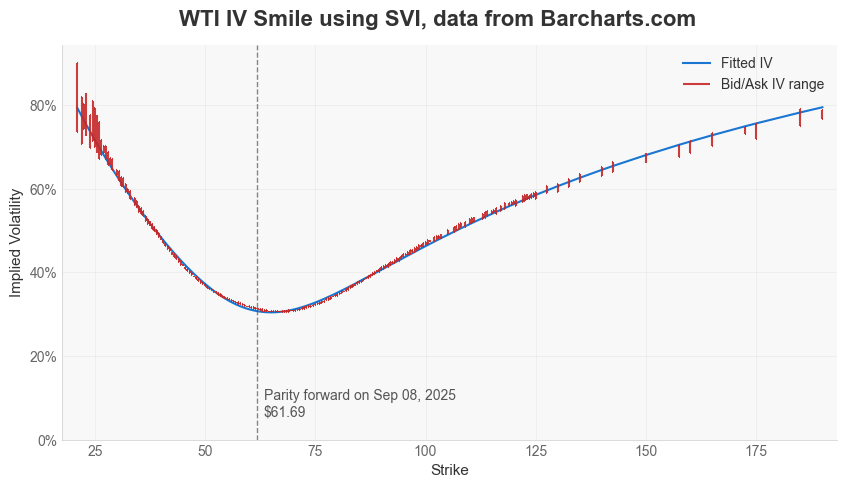

,strike,fitted_iv,bid_iv,ask_iv,last_iv
0,21.0,0.794129,0.737118,0.900171,NaN
1,22.0,0.774035,0.706622,0.820556,NaN
2,22.5,0.764200,0.742500,0.803643,NaN
3,23.0,0.754501,0.727130,0.828387,NaN
4,24.0,0.735485,0.697383,0.776363,NaN
...,...,...,...,...,...
198,165.0,0.728246,0.703378,0.734346,NaN
199,172.5,0.749741,0.730276,0.747358,NaN
200,175.0,0.756618,0.718145,0.756170,NaN
201,185.0,0.782816,0.750739,0.790008,NaN


In [5]:
# plot fitted IV smile
est_wti.plot('iv_smile', title="WTI IV Smile using SVI, data from Barcharts.com")
plt.show()

est_wti.iv_smile()

/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/io/reader.py:92: UserWarning: Optional columns not present: {'last_trade_date'}.
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/prep.py:108: UserWarning: Filled missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/svi.py:967: UserWarning: SVI calibration violates butterfly condition: min_g=-5.195e-03
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/density.py:29: UserWarning: Non-uniform grid detected. Using np.gradient fallback which may be less stable. Consider interpolating to a uniform grid first.
  warnings.warn(


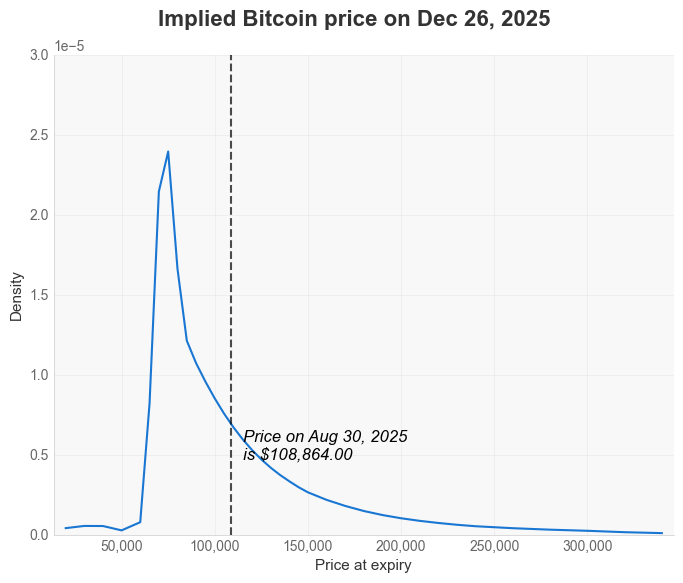

0.23512370556500717

In [8]:
# --- Example 3 - Bitcoin --- # 
# options data from Deribit BTC-USDC
# https://www.deribit.com/options/BTC_USDC

#     strike , last_price , bid , ask
column_mapping_bitcoin = {
    "Strike": "strike",
    "Last_USD": "last_price",
    "Bid_USD": "bid",
    "Ask_USD": "ask",
    "OptionType": "option_type",
}

# 2️⃣  market parameters
market_bitcoin = MarketInputs(
    underlying_price=108864,  # current price of the underlying instrument
    valuation_date=date(2025, 8, 30),
    expiry_date=date(2025, 12, 26),
    risk_free_rate=0.04199,  # US 3-month nominal Treasury yield
)

# 3️⃣  optional model knobs (could omit)
model_bitcoin = ModelParams(
    price_method="mid",
    max_staleness_days=None,
    surface_method="svi",
)

# 4️⃣  run using S&P500 e-mini futures options chain
est_bitcoin = RND.from_csv(
    "data/bitcoin_date20250830_strike20251226_price108864.csv",
    market_bitcoin,
    model=model_bitcoin,
    column_mapping=column_mapping_bitcoin,
)

# PDF only
fig = est_bitcoin.plot(
    kind="pdf",
    figsize=(8, 6),
    title="Implied Bitcoin price on Dec 26, 2025",
)
plt.show()

est_bitcoin.prob_at_or_above(130000)

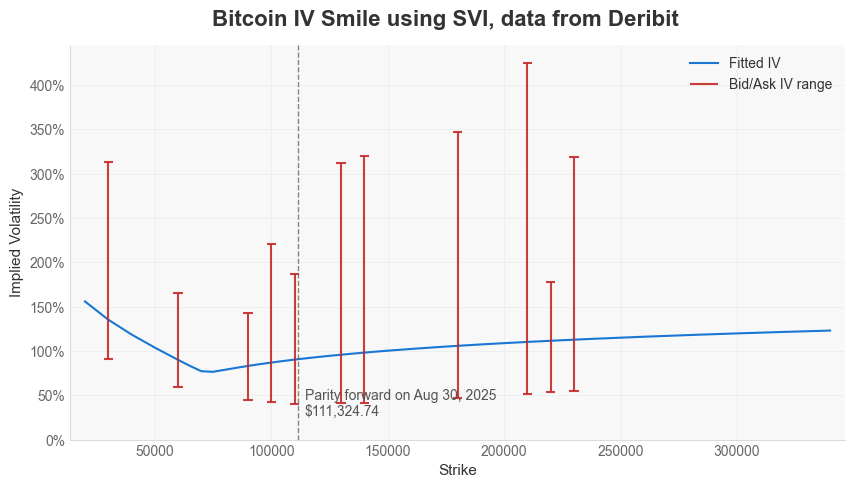

,strike,fitted_iv,bid_iv,ask_iv,last_iv
0,20000.0,1.559108,NaN,1.016404,NaN
1,30000.0,1.353379,3.128206,0.914530,NaN
2,40000.0,1.186026,NaN,0.775634,NaN
3,50000.0,1.037946,NaN,0.673715,NaN
4,60000.0,0.899574,1.648879,0.591519,NaN
5,65000.0,0.832557,NaN,0.558628,NaN
6,70000.0,0.771480,NaN,0.531905,NaN
7,75000.0,0.764869,NaN,0.503180,NaN
8,80000.0,0.787296,NaN,0.477518,NaN
9,85000.0,0.809902,NaN,0.460163,NaN


In [3]:
# plot fitted IV smile
est_bitcoin.plot('iv_smile', title="Bitcoin IV Smile using SVI, data from Deribit")
plt.show()

est_bitcoin.iv_smile()

/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/io/reader.py:92: UserWarning: Optional columns not present: {'last_trade_date'}.
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/prep.py:108: UserWarning: Filled missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/density.py:29: UserWarning: Non-uniform grid detected. Using np.gradient fallback which may be less stable. Consider interpolating to a uniform grid first.
  warnings.warn(


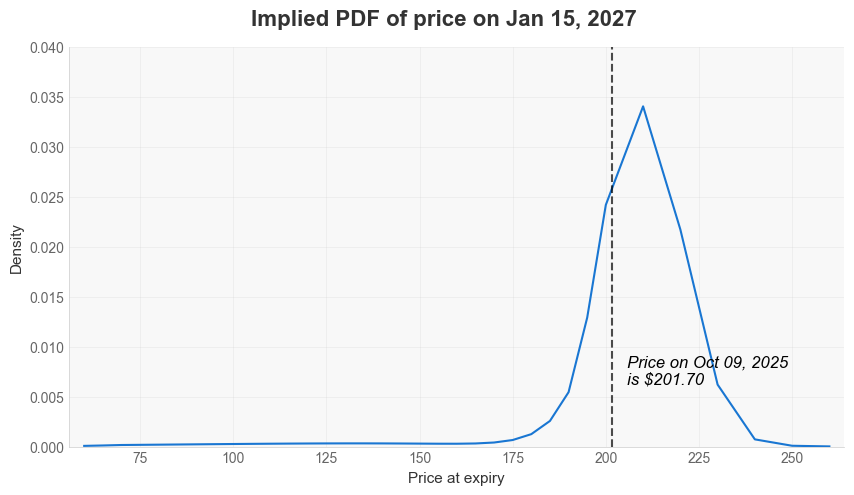

'Underlying price 201.7000 (source: user), implied forward price 205.7930; dividends: none, forward-implied annualised dividend yield of 2.5073%; days_to_expiry=463; r=0.040909909496346056;'

In [8]:
# --- Example 4 - EA, active acquisition offer!!! --- #
# --- using csv --- #

#     strike , last_price , bid , ask
column_mapping_ea = {
    "Strike": "strike",
    "Last": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "OptionType": "option_type",
}

# 1. Use ticker data with market parameters 
market = MarketInputs(
    valuation_date=date.today(),
    expiry_date=date(2027, 1, 15),
    risk_free_rate=0.04199, # US 3-month nominal Treasury yield
    underlying_price=201.70,
)

model_ea = ModelParams(price_method="mid", max_staleness_days=5, surface_method="svi")

# 3. Fetch and estimate - auto-fetched data is available in the result
est_ea = RND.from_csv(
    "data/EA_date2025Oct1_expiry2027Jan15_price_20170.csv",
    market,
    model=model_ea,
    column_mapping=column_mapping_ea,
)

# 4. Check the final market parameters used in estimation
est_ea.market

# 5. Plot using the result object
est_ea.plot(kind='pdf') # optional: `kind="pdf"` or `kind="cdf"`
plt.show()

# 6. Access results
# probability of price at or above a certain level
est_ea.prob_at_or_above(100)

# probability of price below a certain level
est_ea.prob_below(210)

# get results as a dataframe
est_ea.to_frame()

# see all the parameters that were used in the estimation
est_ea.summary()


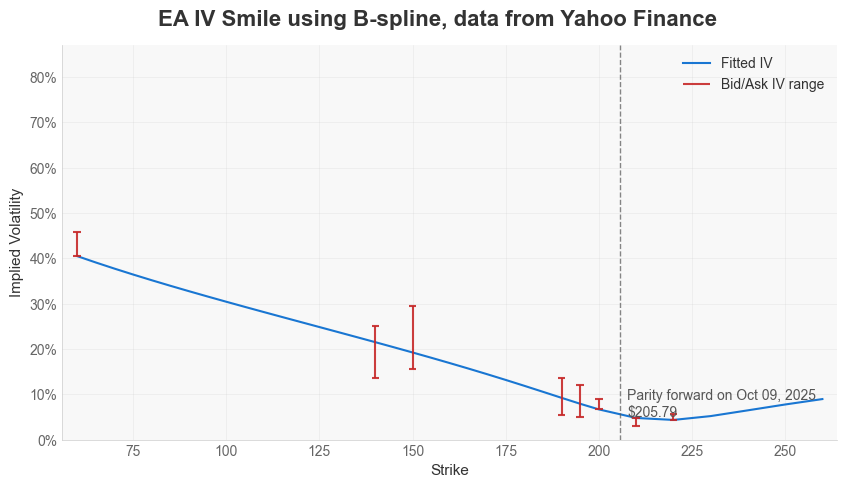

,strike,fitted_iv,bid_iv,ask_iv,last_iv
0,60.0,0.404868,0.405360,0.458481,NaN
1,65.0,0.390773,NaN,0.830114,NaN
2,70.0,0.377262,NaN,0.781317,NaN
3,75.0,0.364243,NaN,0.736368,NaN
4,80.0,0.351640,NaN,0.694687,NaN
5,85.0,0.339386,NaN,0.486112,NaN
6,90.0,0.327425,NaN,0.528619,NaN
7,95.0,0.315710,NaN,0.739650,NaN
8,100.0,0.304195,NaN,0.470223,NaN
9,105.0,0.292841,NaN,0.443222,NaN


In [9]:
# plot fitted IV smile
est_ea.plot('iv_smile', title="EA IV Smile using B-spline, data from Yahoo Finance")
plt.show()

est_ea.iv_smile()

/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/density.py:29: UserWarning: Non-uniform grid detected. Using np.gradient fallback which may be less stable. Consider interpolating to a uniform grid first.
  warnings.warn(


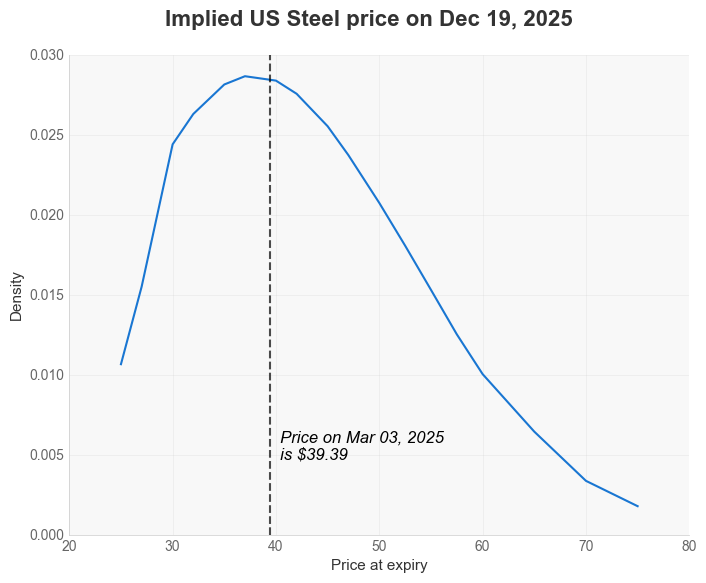

0.21933199828164618


In [ ]:
# --- Example 5 - US Steel --- # 
# Note I only saved the data for calls, missing puts

# 1) column mapping (CSV headers → OIPD fields)
column_mapping_us_steel = {
    "Strike": "strike",
    "Last Price": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "Last Trade Date (EST)": "last_trade_date",
    # No option_type column in this CSV
}

# 2) market parameters
market_us_steel = MarketInputs(
    underlying_price=39.39,
    valuation_date=date(2025, 3, 3),
    expiry_date=date(2025, 12, 19),
    risk_free_rate=0.04199,
)

# 3) optional model knobs (Black–Scholes for equity)
model_us_steel = ModelParams(
    pricing_engine="bs",
    solver="brent",
    price_method="mid",
    max_staleness_days=None,
    surface_method="bspline",
)

# 4) run using US Steel options chain (CSV)
est_us_steel = RND.from_csv(
    "data/ussteel_date20250303_strike20251219_price3939.csv",
    market_us_steel,
    model=model_us_steel,
    column_mapping=column_mapping_us_steel,
)

# Plot PDF
fig = est_us_steel.plot(
    kind="pdf",
    figsize=(8, 6),
    xlim=(20, 80),
    title="Implied US Steel price on Dec 19, 2025",
)
plt.show()

# Example probability query
prob = est_us_steel.prob_at_or_above(55)
print(prob)



### Back in Mar 2025, US Steel was an interesting example. 

The distribution is bimodal, and given Nippon Steel's proposed $55 per share acquisition, it can be thought of as two overlapping scenarios:

1. Acquisition is approved:
    - In this scenario, the share price would likely move above the $55 per share offer. This creates a "second peak" in the distribution
    - By inspecting the cumulative probability, we see there's a 21% probability that the deal is approved and price rises above $55

2. Acquisition falls apart:
    - Without the approval, the share price may drop back toward a level driven by "business as usual" fundamentals—here, that appears lower than the current $39.39. This is the "first peak" in the distribution